In [288]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/AVP-BDD/'
os.chdir(path)


In [289]:
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)
subjects = layout.get_subjects()

def load_bids_events(layout,onsets, subject, task, run):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]
    onsets=onsets[run]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [1,4,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans


def create_low_events_file(file_path):
    data = pd.read_csv(file_path)  # Adjust delimiter if necessary

    # Define category mapping
    condition_mapping = {
        "Condition 1": "low-high", "Condition 2": "high-high", "Condition 3": "low-low", "Condition 4": "high-low"
    }

    data["Condition"] = data["Condition"].map(condition_mapping)

    # Extract unique blocks
    block_summary = data.groupby("Block").agg({
        "Stimulus Onset (s)": "first",
        "Stimulus Offset (s)": "last",
        "Condition": "first"
    }).reset_index()

    # Rename columns for clarity
    block_summary.rename(columns={
        "Stimulus Onset (s)": "onset",
        "Stimulus Offset (s)": "block_end",
        "Condition": "trial_type"
    }, inplace=True)
    
    block_summary["duration"] = block_summary["block_end"]-block_summary["onset"]
    block_summary["onset"] = np.round(block_summary["onset"])
    block_summary["duration"] = np.round(block_summary["duration"])

    # Save the processed data
    output_path = "/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/events.csv"
    block_summary.to_csv(output_path, index=False)
    return block_summary



BIDS Layout: ...ktop Drive/AVP-BDD/derivatives | Subjects: 24 | Sessions: 24 | Runs: 72


In [315]:

onsets = []
sub = '105' 
runs = ['1','2','3']
for run in runs:
    file_path = f"/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/sub-{sub}/ses-01/func/Subject_{sub}_Run_1_RT.csv"
    onsets_temp = create_low_events_file(file_path)
    onsets.append(onsets_temp)

onsets

In [316]:
onsets

[    Block  onset   block_end trial_type  duration
 0       1    0.0   12.112672   low-high      12.0
 1       2   22.0   34.325003    low-low      12.0
 2       3   45.0   56.539862   high-low      12.0
 3       4   67.0   78.771341  high-high      12.0
 4       5   89.0  101.002282   high-low      12.0
 5       6  111.0  123.220686    low-low      12.0
 6       7  133.0  145.444702   high-low      12.0
 7       8  156.0  167.665734   low-high      12.0
 8       9  178.0  189.898964  high-high      12.0
 9      10  200.0  212.122126    low-low      12.0
 10     11  222.0  234.337793   low-high      12.0
 11     12  245.0  256.556355   low-high      12.0
 12     13  267.0  278.775313  high-high      12.0
 13     14  289.0  300.990593    low-low      12.0
 14     15  311.0  323.209081   high-low      12.0
 15     16  333.0  345.427322  high-high      12.0,
     Block  onset   block_end trial_type  duration
 0       1    0.0   12.112672   low-high      12.0
 1       2   22.0   34.325003 

In [317]:
sub = sub
task = 'SFlow'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,
              desc='preproc',
              space='MNI152NLin2009cAsym',
              extension='nii.gz',
              return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []
for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,onsets, sub, task, run)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list
    design_matrices.append(design_matrix)


contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"all": (basic_contrasts["low-low"] + basic_contrasts["low-high"] + basic_contrasts["high-low"] + basic_contrasts["high-high"]),          
}
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_86695/1952182048.py:4: UserWarning: One contrast given, assuming it for all 3 runs
  z_map = fmri_glm.compute_contrast(contrasts['all'], output_type="z_score")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=5.118127927025583.
  stat_img = threshold_img(


\begin{tabular}{lllllll}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
\bottomrule
\end{tabular}



/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_86695/1952182048.py:22: UserWarning: Attention: No clusters with stat higher than 5.118127927025583
  table = get_clusters_table(clean_map, threshold, 10)


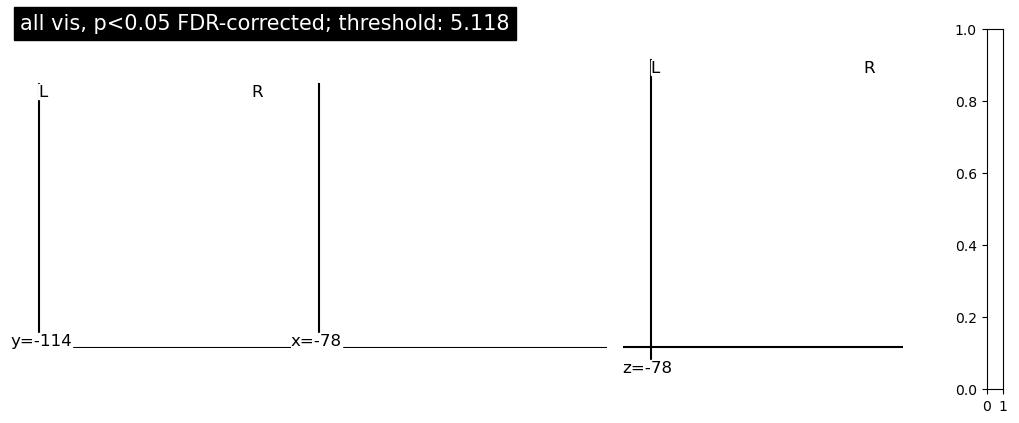

In [318]:
from nilearn.glm import threshold_stats_img
from nibabel import Nifti1Image

z_map = fmri_glm.compute_contrast(contrasts['all'], output_type="z_score")

clean_map, threshold = threshold_stats_img(z_map, alpha=0.05,height_control='fdr',cluster_threshold=30, two_sided=False)
plot_stat_map(clean_map,
    threshold=threshold,
    title=(f"all vis, p<0.05 FDR-corrected; threshold: {threshold:.3f}"),
    figure=plt.figure(figsize=(10, 4))
    )

#binarize mask 
data = clean_map.get_fdata()
binarized_data = (data > 0).astype(bool)
vis_mask = Nifti1Image(binarized_data, z_map.affine, header=z_map.header)
vis_mask.shape

# cluster summary table 

from nilearn.reporting import get_clusters_table
table = get_clusters_table(clean_map, threshold, 10)
print(table.to_latex())



/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


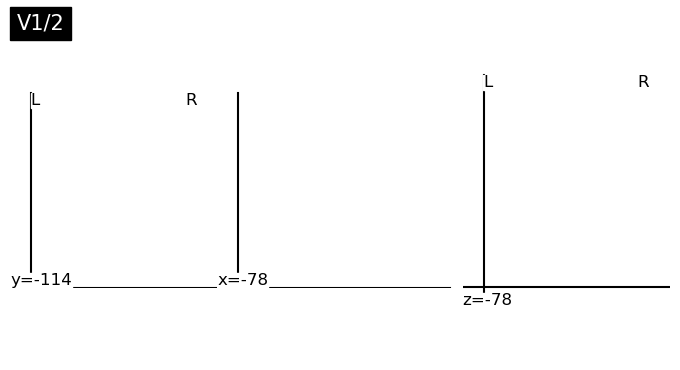

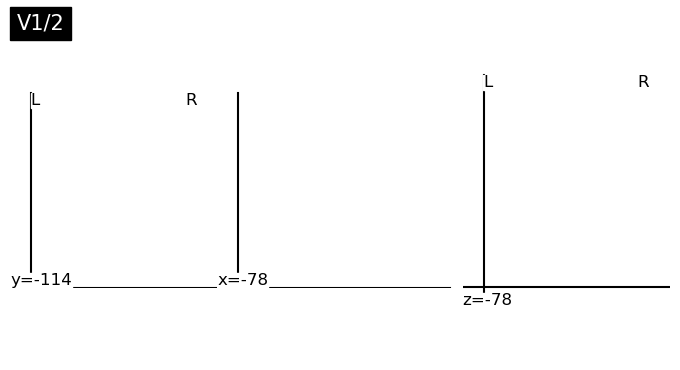

In [319]:
from nilearn.plotting import plot_roi, show
plot_roi(vis_mask,
    title='V1/2',
)

#adding dilation: 

from scipy.ndimage import binary_dilation
data = binary_dilation(binarized_data)
vis_mask_dil = Nifti1Image(data, z_map.affine, header=z_map.header)
plot_roi(vis_mask_dil,
    title='V1/2',
)


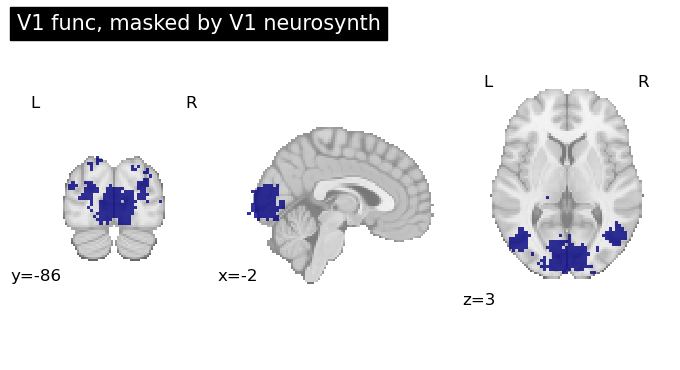

In [331]:
#Also masking w neurosynth v1? 
from nilearn.image import new_img_like
from nilearn.image import resample_to_img 

#import DMN Neurosynth mask:
v1_raw = load_img('/Volumes/Seagate Desktop Drive/AVP-BDD/v1.nii.gz')
v1 = resample_to_img(source_img=v1_raw, target_img=vis_mask_dil, interpolation='nearest')

#v1_mask = np.logical_and(vis_mask_dil.get_fdata(),v1.get_fdata())
#binarize mask 

data = v1.get_fdata()
binarized_data = (data > 0).astype(bool)
v1_mask = Nifti1Image(binarized_data, v1.affine, header=v1.header)

plotting.plot_roi(v1_mask, draw_cross=False, alpha=0.8, title="V1 func, masked by V1 neurosynth")



Extracting signal just from V1/V2 activated in all conditions 

[    Block  onset   block_end trial_type  duration
 0       1    0.0   12.124860  high-high      12.0
 1       2   22.0   34.348864   low-high      12.0
 2       3   45.0   56.567364  high-high      12.0
 3       4   67.0   78.792372    low-low      12.0
 4       5   89.0  101.009835    low-low      12.0
 5       6  111.0  123.244728   high-low      12.0
 6       7  133.0  145.475327   high-low      12.0
 7       8  156.0  167.700337    low-low      12.0
 8       9  178.0  189.925855   low-high      12.0
 9      10  200.0  212.143254   low-high      12.0
 10     11  222.0  234.372208  high-high      12.0
 11     12  245.0  256.593359    low-low      12.0
 12     13  267.0  278.812173  high-high      12.0
 13     14  289.0  301.041447   high-low      12.0
 14     15  311.0  323.266147   low-high      12.0
 15     16  333.0  345.497005   high-low      12.0,
     Block  onset   block_end trial_type  duration
 0       1    0.0   12.124860  high-high      12.0
 1       2   22.0   34.348864 

In [403]:
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker

# for typical ROI analysis -- will assign 1 value to the V1/V2 ROI extracted above 
# First, initialize masker 
# masker = NiftiLabelsMasker(
#     vis_mask_dil
# )

masker = NiftiLabelsMasker(
    v1_mask
)

# for small volume cluster correction -- allows values to vary within predefined ROI mask 
# masker = NiftiMasker(
#     maps_img = vis_mask_dil,
# )

In [429]:
onsets = []
sub = '102' 
runs = ['1','2','3']
for run in runs:
    file_path = f"/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/sub-{sub}/ses-01/func/Subject_{sub}_Run_1_RT.csv"
    onsets_temp = create_low_events_file(file_path)
    onsets.append(onsets_temp)

task = 'SFlow'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,
              desc='preproc',
              space='MNI152NLin2009cAsym',
              extension='nii.gz',
              return_type='file')

hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

time_series = []
for con_img in fmri_imgs:
    time_series.append(masker.fit_transform(con_img))
time_series = np.concatenate(time_series, axis = 0)


confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []
for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,onsets, sub, task, run)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:-1] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0) 

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"low-high": (basic_contrasts["low-high"]),
"hig-high": (basic_contrasts["high-high"]),
"low-low": (basic_contrasts["low-low"]),
"high-low": (basic_contrasts["high-low"]),
"high": (basic_contrasts["high-high"] - basic_contrasts["high-low"]),
"low": (basic_contrasts["low-high"] - basic_contrasts["low-low"])
}

labels, estimates = run_glm(time_series, design_matrix_allruns)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val)        
    z_score = contrast.z_score()
    effect_size = contrast.effect_size()
    print(f"{contrast_id}: Z-score outputs: {z_score}") 
    print(f"{contrast_id}: Beta outputs: {effect_size}")
        

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


low-high: Z-score outputs: [3.98009927]
low-high: Beta outputs: [[16.11568887]]
hig-high: Z-score outputs: [3.40382495]
hig-high: Beta outputs: [[14.04266811]]
low-low: Z-score outputs: [0.98229646]
low-low: Beta outputs: [[3.91367296]]
high-low: Z-score outputs: [1.78154007]
high-low: Beta outputs: [[7.17498077]]
high: Z-score outputs: [1.28597512]
high: Beta outputs: [[6.86768733]]
low: Z-score outputs: [2.33384059]
low: Beta outputs: [[12.20201591]]


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


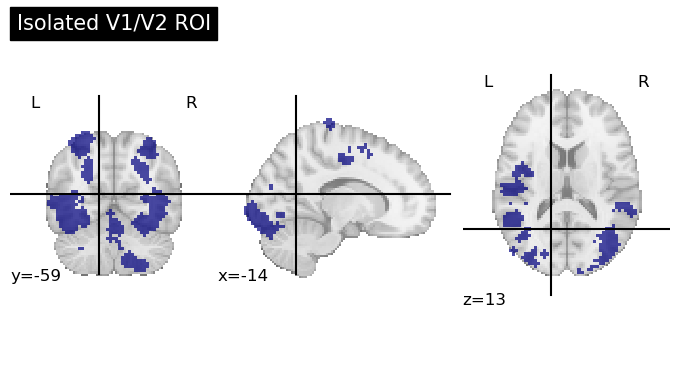

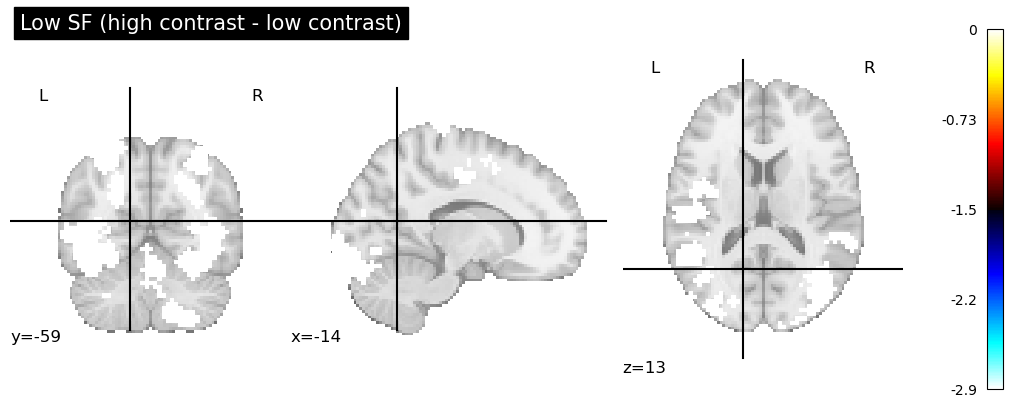

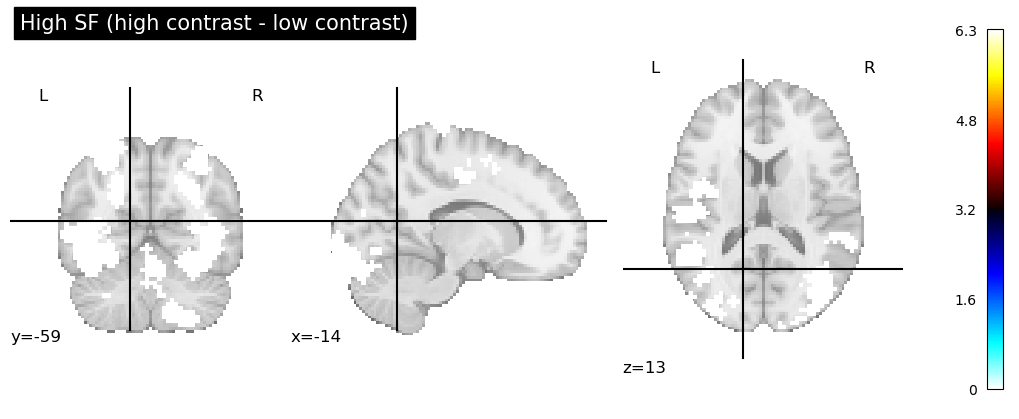

In [255]:
# graphing values on brain 

import numpy as np
from nibabel import Nifti1Image

def update_ROI_vals(arr, updated_val):
    arr = arr.copy()  
    arr[arr == 1] = updated_val  
    return arr

# Get the 3D NumPy array from the NIfTI image
mask_data = vis_mask_dil.get_fdata()

# Update values
P001_low_data = update_ROI_vals(mask_data, -2.92147382)
P001_high_data = update_ROI_vals(mask_data, 6.33787545)

# Convert back to NIfTI images
P001_low = Nifti1Image(P001_low_data, vis_mask_dil.affine, header=vis_mask_dil.header)
P001_high = Nifti1Image(P001_high_data, vis_mask_dil.affine, header=vis_mask_dil.header)

# Plot
plot_roi(P001_low, title='Isolated V1/V2 ROI')
plot_stat_map(P001_low,
    threshold=0,
    title=(f"Low SF (high contrast - low contrast)"),
    figure=plt.figure(figsize=(10, 4))
    )
plot_stat_map(P001_high,
    threshold=0,
    title=(f"High SF (high contrast - low contrast)"),
    figure=plt.figure(figsize=(10, 4))
    )